In [1]:
# Модель
import lightgbm 
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold

# Пайплайн
from sklearn.pipeline import Pipeline
from helpers.data import DataPreprocessor
from helpers.validation import valid_predictions

# Данные
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import shap

# Настройки вывода
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [107]:
# Пути
ROOT = os.getcwd()
TRAIN_DATASET = os.path.join(ROOT, '../data/train_AIC.csv')
BALANCED_DATASET = os.path.join(ROOT, '../data/balanced_train.csv')
TEST_DATASET = os.path.join(ROOT, '../data/test_AIC.csv')
SUBMISSION_PATH = os.path.join(ROOT, '../submissions/')
MODEL_SAVE_PATH = os.path.join(ROOT, '../output/lgbm_model.dat')

# Функции
def make_predictions(model: object | Pipeline, X_test: pd.DataFrame) -> Pipeline:
    """ Функция создания предсказаний для тестовой выборки.
    
    Обучает переданную модель на сбалансированном датасете, учитывая выбросы.
    Предсказания сохраняются с помощью функции save_submission.
    
    Параметры:
        model: Модель или пайплайн, используемый для обучения и предсказания меток
            тестовой выборки.
        X_test: Тестовая выборка, для которой будут сделаны предсказания.
            Экземпляр pandas.DataFrame.
            
    Возвращает пайплайн модели для инференса."""

    # Балансировка
    positive_entries = train_df[train_df['y'] == 1]
    negative_count = len(train_df[train_df['y'] == 0])
    positive_count = len(positive_entries)
    balanced_df = pd.concat([train_df, positive_entries])
    for _ in range(int(negative_count / positive_count) - 1):
        balanced_df = pd.concat([balanced_df, positive_entries])
    
    # Обрезка негативных записей до числа позитивных
    first_negatives = balanced_df[balanced_df['y'] == 0][:balanced_df[balanced_df['y'] == 1]['y'].count()]
    balanced_df = pd.concat([balanced_df[balanced_df['y'] == 1], first_negatives])

    # Удаление выбросов
    balanced_df = balanced_df[balanced_df['Длительность'] < 400]
    balanced_df = balanced_df[(balanced_df['Сумма'] > 2) & (balanced_df['Сумма'] < 10)]
    balanced_df = balanced_df[balanced_df['До поставки'] < 300]
    balanced_df = balanced_df[balanced_df['Дней между 0_1'] < 400]
    balanced_df = balanced_df[balanced_df['Количество изменений после согласований'] < 2000]
    balanced_df = balanced_df[balanced_df['Количество'] < 300000]
    
    # Разделение независимых и независимых переменных
    X, y = balanced_df.iloc[:, :-1], balanced_df.iloc[:, -1]   

    # Обучение модели и создание предсказаний для тестовой выборки
    model.fit(X, y)
    preds = model.predict(X_test)

    # Сохранение предсказаний
    save_submission(preds, 'submission')
    return model
    
def save_submission(preds: list | pd.DataFrame | pd.arrays.PandasArray, subname: str) -> None:
    subname = os.path.join(SUBMISSION_PATH, f'{subname}.csv')
    submit_df = pd.DataFrame({'id': test_df.index, 'value': preds})
    submit_df.to_csv(subname, index=False)


# Загрузка датасетов
train_df = pd.read_csv(TRAIN_DATASET)
test_df = pd.read_csv(TEST_DATASET)

# Удаление дубликатов из тренировочной выборки
train_df = train_df.drop_duplicates()

# Разделение выборки на тренировочную и тестовую
X, y = train_df.iloc[:, :-1], train_df.iloc[:, -1]   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Удаление выбросов из тренировочной выборки
X_train = pd.concat([X_train, y_train], axis=1) # Объединяем X_train и y_train
X_train = X_train[X_train['Длительность'] < 400]
X_train = X_train[(X_train['Сумма'] > 2) & (X_train['Сумма'] < 10)]
X_train = X_train[X_train['До поставки'] < 300]
X_train = X_train[X_train['Дней между 0_1'] < 400]
X_train = X_train[X_train['Количество изменений после согласований'] < 2000]
X_train = X_train[X_train['Количество'] < 300000]

# Отделяем метки классов от признаков
y_train = X_train['y']
X_train = X_train.drop('y', axis=1)

# Общий датасет для большего числа записей, используемых на кросс-валидации
X_general, y_general = train_df.iloc[:, :-1], train_df.iloc[:, -1]

In [3]:
import pickle

# Импорт модели
model = None
with open(MODEL_SAVE_PATH, 'rb') as file:
    model = pickle.load(file)

In [4]:
# Запуск кросс-валидации
cv_scores = cross_val_score(model, X_general, y_general, cv=KFold(n_splits=500), scoring='f1_macro', n_jobs=-1)
print(f'Mean F1-macro: {cv_scores.mean()}')

Mean F1-macro: 0.9071784724565153


In [5]:
print(cv_scores)

[0.86679362 0.92492978 0.90933388 0.92175919 0.92173219 0.92984607
 0.88828926 0.90022624 0.89536238 0.91691003 0.9004065  0.91559001
 0.908166   0.89377559 0.88259828 0.9086124  0.88348745 0.91500482
 0.90503876 0.96392891 0.94056604 0.91306576 0.90073827 0.87897053
 0.94292494 0.91066445 0.89947364 0.92282035 0.92474176 0.87616798
 0.89942551 0.91421902 0.91700542 0.89772727 0.92948191 0.90586597
 0.87037037 0.87911184 0.93440428 0.88380759 0.95020325 0.91880115
 0.92872727 0.88828926 0.88259828 0.9143874  0.93518836 0.88190495
 0.90550491 0.90586597 0.915546   0.88932612 0.89277378 0.91194871
 0.902      0.86915034 0.85731234 0.91664867 0.89942551 0.92331974
 0.90703394 0.89947364 0.8832756  0.90474133 0.92181259 0.90959301
 0.92492978 0.91623932 0.89567891 0.92369488 0.88648649 0.91090909
 0.92609351 0.9092637  0.87312565 0.92268583 0.90011868 0.91818182
 0.93359567 0.92592593 0.908166   0.94212598 0.90652379 0.90500539
 0.9143874  0.86484544 0.91880115 0.88047221 0.92986641 0.8919

In [6]:
splits = KFold.get_n_splits(KFold(n_splits=500), X_general, y_general)

In [4]:
scores = [0.86679362, 0.92492978, 0.90933388, 0.92175919, 0.92173219, 0.92984607, 
          0.88828926, 0.90022624, 0.89536238, 0.91691003, 0.9004065, 0.91559001, 
          0.908166, 0.89377559, 0.88259828, 0.9086124, 0.88348745, 0.91500482, 
          0.90503876, 0.96392891, 0.94056604, 0.91306576, 0.90073827, 0.87897053, 
          0.94292494, 0.91066445, 0.89947364, 0.92282035, 0.92474176, 0.87616798, 
          0.89942551, 0.91421902, 0.91700542, 0.89772727, 0.92948191, 0.90586597, 
          0.87037037, 0.87911184, 0.93440428, 0.88380759, 0.95020325, 0.91880115, 
          0.92872727, 0.88828926, 0.88259828, 0.9143874, 0.93518836, 0.88190495, 
          0.90550491, 0.90586597, 0.915546, 0.88932612, 0.89277378, 0.91194871, 
          0.902, 0.86915034, 0.85731234, 0.91664867, 0.89942551, 0.92331974, 
          0.90703394, 0.89947364, 0.8832756, 0.90474133, 0.92181259, 0.90959301, 
          0.92492978, 0.91623932, 0.89567891, 0.92369488, 0.88648649, 0.91090909, 
          0.92609351, 0.9092637, 0.87312565, 0.92268583, 0.90011868, 0.91818182, 
          0.93359567, 0.92592593, 0.908166, 0.94212598, 0.90652379, 0.90500539, 
          0.9143874, 0.86484544, 0.91880115, 0.88047221, 0.92986641, 0.89190758, 
          0.89309091, 0.92181259, 0.93602868, 0.89557187, 0.93500368, 0.90638512, 
          0.90354331, 0.91775116, 0.8858089, 0.91818182, 0.88828926, 0.89448751, 
          0.92614126, 0.91024776, 0.88470812, 0.87626263, 0.89309091, 0.88739467, 
          0.91559001, 0.86704854, 0.92609351, 0.95135135, 0.87536505, 0.86762784, 
          0.88832077, 0.92239819, 0.91090909, 0.91743119, 0.93009247, 0.87633736, 
          0.91588785, 0.8908121, 0.90638512, 0.90712984, 0.92445756, 0.90870596, 
          0.94962993, 0.92173219, 0.92445756, 0.87372449, 0.89008628, 0.95130349, 
          0.86915128, 0.89033488, 0.90795455, 0.92782324, 0.87727273, 0.93669251, 
          0.90933388, 0.93009247, 0.91818182, 0.94124477, 0.92080374, 0.9035755, 
          0.93051679, 0.91374039, 0.90810811, 0.91691003, 0.90795455, 0.92328117, 
          0.89653092, 0.91858255, 0.88648649, 0.91743119, 0.8714139, 0.87132854, 
          0.8728148, 0.87633736, 0.90638512, 0.92688992, 0.91409537, 0.9035755, 
          0.8746975, 0.9161395, 0.92500425, 0.87768465, 0.91200415, 0.89238176, 
          0.90767035, 0.91664867, 0.9261279, 0.91696926, 0.89567891, 0.91700542, 
          0.89613754, 0.93914603, 0.87837678, 0.94242615, 0.85829049, 0.90487489, 
          0.90292015, 0.81771543, 0.89947364, 0.90466043, 0.88500652, 0.90810811, 
          0.91421902, 0.94845722, 0.88425197, 0.94845722, 0.90959301, 0.91790526, 
          0.89173486, 0.92688992, 0.88648649, 0.89342555, 0.94806877, 0.93768252, 
          0.92283465, 0.87037037, 0.90466043, 0.92379626, 0.92840909, 0.8937767, 
          0.92604203, 0.91790526, 0.92740881, 0.89818003, 0.92077147, 0.92609351, 
          0.88418182, 0.90933388, 0.9035755, 0.9049581, 0.89178673, 0.92379626, 
          0.94044296, 0.88425197, 0.92239819, 0.93190031, 0.9086124, 0.88393626, 
          0.91559001, 0.89942551, 0.92283465, 0.87132854, 0.90586597, 0.8825953, 
          0.87117468, 0.86060591, 0.90216523, 0.92445756, 0.88995994, 0.91666667, 
          0.91145046, 0.91818182, 0.88425197, 0.89448751, 0.873587, 0.92740881, 
          0.93009247, 0.9143874, 0.915546, 0.92270481, 0.88520408, 0.91858255, 
          0.90959301, 0.89895689, 0.91969536, 0.89800324, 0.87897053, 0.88181976, 
          0.90703394, 0.8908121, 0.94516744, 0.90073827, 0.91886867, 0.90500539, 
          0.93518519, 0.91194871, 0.90178839, 0.88032564, 0.91372545, 0.92494165, 
          0.90212946, 0.86915034, 0.91818182, 0.92270481, 0.8875, 0.86176867, 
          0.91500482, 0.87742055, 0.91505381, 0.92816108, 0.9065643, 0.90189342, 
          0.91969536, 0.92960332, 0.91239878, 0.91520551, 0.91374039, 0.90212946, 
          0.90559441, 0.91338384, 0.90212946, 0.89972581, 0.92604203, 0.91374039, 
          0.91666667, 0.8875, 0.94574978, 0.91163934, 0.92059062, 0.90652379, 
          0.90320457, 0.89567891, 0.8858089, 0.8622449, 0.8832756, 0.8875, 
          0.94382991, 0.91880115, 0.93248031, 0.88828926, 0.90977905, 0.91969536, 
          0.91483112, 0.91691209, 0.9065643, 0.92181259, 0.91066445, 0.91318898, 
          0.93500368, 0.9374036, 0.89135255, 0.94020963, 0.91102223, 0.9092637, 
          0.92181259, 0.93195818, 0.93413573, 0.9214902, 0.92071122, 0.90360656, 
          0.8714139, 0.92609351, 0.89033488, 0.92592593, 0.93914603, 0.88393626, 
          0.902, 0.8759335, 0.89389764, 0.90559441, 0.92500425, 0.92782324, 
          0.91509434, 0.95545455, 0.90933388, 0.89173486, 0.88088593, 0.87000539, 
          0.90071795, 0.89726575, 0.88914846, 0.90656371, 0.93682051, 0.92911686, 
          0.87834262, 0.88914846, 0.91128585, 0.90897113, 0.88144191, 0.91302973, 
          0.90337861, 0.94498437, 0.91029039, 0.88735279, 0.94442339, 0.88465907, 
          0.92387214, 0.94514628, 0.91815476, 0.93682051, 0.87532468, 0.90649351, 
          0.91099371, 0.92172676, 0.91740191, 0.88266667, 0.904973, 0.89417657, 
          0.94240769, 0.86482335, 0.91435616, 0.90974359, 0.90930328, 0.92033315, 
          0.9007041, 0.88884679, 0.91551459, 0.88735279, 0.90956463, 0.89810955, 
          0.88005551, 0.92490186, 0.92611783, 0.90484017, 0.91087344, 0.88571429, 
          0.9169686, 0.93682051, 0.90484017, 0.91505792, 0.92376604, 0.89234397, 
          0.91551459, 0.86270898, 0.93516126, 0.93049287, 0.88789809, 0.93837782, 
          0.90337861, 0.88421053, 0.94042246, 0.88910731, 0.91815476, 0.90316514, 
          0.92384996, 0.8864563, 0.9007041, 0.94572592, 0.90763006, 0.85333333, 
          0.8955398, 0.91370679, 0.85454545, 0.90174662, 0.9527745, 0.92280702, 
          0.90768449, 0.91855312, 0.9005806, 0.89077451, 0.90956463, 0.92957465, 
          0.9197861, 0.92146503, 0.91663509, 0.88914846, 0.88421053, 0.92689411, 
          0.92155759, 0.904973, 0.91424674, 0.90635257, 0.88049509, 0.90897113, 
          0.90484017, 0.92562764, 0.89417657, 0.92384996, 0.91369662, 0.92497869, 
          0.90337861, 0.89532419, 0.93737606, 0.89005105, 0.91663509, 0.92387214, 
          0.8855588, 0.9271684, 0.92146503, 0.9340033, 0.9018636, 0.92779487, 
          0.90019658, 0.89385965, 0.88645161, 0.89234397, 0.92606782, 0.92491834, 
          0.90649351, 0.91889401, 0.90196078, 0.89095956, 0.90213088, 0.91330049, 
          0.91740191, 0.88323661, 0.90582864, 0.89563567, 0.90807988, 0.90653622, 
          0.91435616, 0.90213088, 0.86828931, 0.91889401, 0.90213088, 0.89532419, 
          0.91740191, 0.91740191, 0.86105848, 0.89938915, 0.90206071, 0.91237011, 
          0.93273474, 0.86700149, 0.89320285, 0.90806603, 0.88413547, 0.89943484, 
          0.91889401, 0.91556323, 0.86910839, 0.87532468, 0.92838542, 0.8980695, 
          0.92611783, 0.89813892]

In [108]:
kfold = KFold(n_splits=500)
bad_samples = []
for index, fold in enumerate(kfold.split(X_general, y_general)):
    if scores[index] < 0.9:
        for sample in fold[1]:
            bad_samples.append(sample)

In [64]:
folds = [fold for fold in kfold.split(X_general, y_general)]

In [62]:
len(folds[0][0])

219901

In [24]:
len(bad_samples)

22039

In [86]:
print(X_general[X_general.index == 10195])

Empty DataFrame
Columns: [Поставщик, Материал, Категорийный менеджер, Операционный менеджер, Завод, Закупочная организация, Группа закупок, Балансовая единица, ЕИ, Группа материалов, Вариант поставки, НРП, Длительность, До поставки, Месяц1, Месяц2, Месяц3, День недели 2, Сумма, Количество позиций, Количество, Количество обработчиков 7, Количество обработчиков 15, Количество обработчиков 30, Согласование заказа 1, Согласование заказа 2, Согласование заказа 3, Изменение даты поставки 7, Изменение даты поставки 15, Изменение даты поставки 30, Отмена полного деблокирования заказа на закупку, Изменение позиции заказа на закупку: изменение даты поставки на бумаге, Изменение позиции заказа на закупку: дата поставки, Количество циклов согласования, Количество изменений после согласований, Дней между 0_1, Дней между 1_2, Дней между 2_3, Дней между 3_4, Дней между 4_5, Дней между 5_6, Дней между 6_7, Дней между 7_8]
Index: []

[0 rows x 43 columns]


In [109]:
X_general = pd.concat([X_general, y_general], axis=1)

In [110]:
X_general_prec = X_general.drop(index=bad_samples, axis=0, errors='ignore')

In [111]:
X_general_prec, y_general_prec = X_general_prec.iloc[:, :-1], X_general_prec.iloc[:, -1]

In [112]:
X_general_prec

,Поставщик,Материал,Категорийный менеджер,Операционный менеджер,Завод,Закупочная организация,Группа закупок,Балансовая единица,ЕИ,Группа материалов,...,Количество циклов согласования,Количество изменений после согласований,Дней между 0_1,Дней между 1_2,Дней между 2_3,Дней между 3_4,Дней между 4_5,Дней между 5_6,Дней между 6_7,Дней между 7_8
441,34,27439,5,2,1,1,3,1,1,3,...,4.0,45,143.0,0.0,3.0,0.0,0.0,-1.0,-1.0,-1.0
442,3,13725,10,18,1,8,21,1,1,6,...,3.0,33,1.0,0.0,3.0,0.0,0.0,3.0,-1.0,-1.0
443,134,27439,2,14,1,1,37,1,1,7,...,1.0,0,8.0,0.0,0.0,0.0,1.0,-1.0,-1.0,50.0
444,12,3772,1,16,9,7,13,8,1,3,...,1.0,11,52.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
445,569,5131,1,1,13,13,36,11,5,31,...,1.0,7,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224995,247,1402,1,10,2,2,58,2,1,25,...,2.0,27,14.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0
224996,53,794,1,14,1,1,90,1,1,18,...,1.0,11,1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0
224997,68,2661,4,8,1,1,38,1,1,11,...,2.0,0,-1.0,4.0,4.0,0.0,0.0,-1.0,-1.0,-1.0
224998,1721,186,1,9,3,3,132,3,2,94,...,2.0,26,34.0,7.0,4.0,0.0,0.0,-1.0,-1.0,-1.0


In [113]:
X_train, X_test, y_train, y_test = train_test_split(X_general_prec, y_general_prec, random_state=42, test_size=0.1)

In [114]:
# Параметры модели
parameters = {
    'objective': 'binary',
    'force_col_wise': True,
    'learning_rate': 0.25595401399911066, 
    'n_estimators': 2122, 
    'max_depth': 14, 
    'max_bin': 163, 
    'num_leaves': 176, 
    'reg_lambda': 0.15394653650963538, 
    }

# Предобработчик и модель
data_preprocessor = DataPreprocessor()
model = LGBMClassifier(**parameters, n_jobs=-1)

# Пайплайн
pipeline = Pipeline([
    ('data_preproc', data_preprocessor),
    ('model', model)
])

In [115]:
# Обучение модели и получение предсказаний для тестовой выборки
pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)

[LightGBM] [Info] Number of positive: 19367, number of negative: 114792
[LightGBM] [Info] Total Bins 2579
[LightGBM] [Info] Number of data points in the train set: 134159, number of used features: 103
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.144359 -> initscore=-1.779551
[LightGBM] [Info] Start training from score -1.779551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


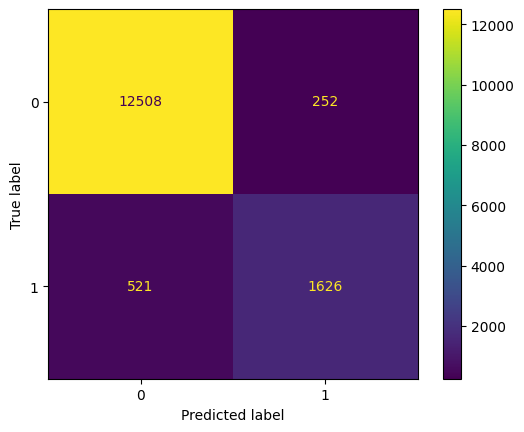

              precision    recall  f1-score   support

           0    0.96001   0.98025   0.97003     12760
           1    0.86581   0.75734   0.80795      2147

    accuracy                        0.94815     14907
   macro avg    0.91291   0.86879   0.88899     14907
weighted avg    0.94645   0.94815   0.94668     14907

F1-macro: 0.888988145314014
ROC-AUC score: 0.8687933005593576
Accuracy: 0.948145166700208


In [116]:
from helpers.validation import valid_predictions
# Вывод результатов валидации
valid_predictions(y_test, preds, pipeline.classes_)